In [1]:
import numpy as np
import pandas as pd
import time
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import joblib
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib
import os

%load_ext autoreload
%autoreload 2
# %matplotlib notebook
%matplotlib inline

# Data Preprocessing

In [2]:
# body_part = "head"
# file_names = ['./training_data/head_train_1_to_6.log']

# body_part = "shoulder_right"
# file_names = [
#              './training_data/shoulder_right_train_10_17.log',
#              './training_data_old/shoulder_right_data_6.log',
#              './training_data_old/shoulder_right_data_7.log',
#              './training_data_old/shoulder_right_data_8.log',
#              './training_data_old/shoulder_right_data_9.log',
#             ]

body_part = "shoulder_left"
# file_names = ['./training_data/shoulder_left_train_2.log',
#               './training_data/shoulder_left_train_5_6_7_9_10.log'
#              ]
file_names = ['./training_data/shoulder_left_train_ts_5_6_7_9_10.log']

In [3]:
orig_dataset = pd.concat([pd.read_csv(f, delim_whitespace=True, header=0) for f in file_names])
orig_dataset = orig_dataset.values[1:len(orig_dataset)-2,1:]
# dataset = [data[(np.abs(stats.zscore(data[["roll", "pitch", "yaw"]])) < 2.75).all(axis=1)] for data in dataset]

abnormal_threshold = 0.5
dataset = []

for name in file_names:
    df = pd.read_csv(name, delim_whitespace=True, header=0)
    
    # interpolate nan outputs (loss tracking)
    for c in df.columns[-3:]:
        df[c] = df[c].interpolate()
    
    # interpolate abnormal inputs
    for c in df.columns[1:-3]:
        bad_idx = df.index[df[c].pct_change().abs().ge(abnormal_threshold)]
        df.loc[bad_idx, c] = np.nan
        df[c] = df[c].interpolate()
    
    # Add action
    for c in df.columns[-3:]:
        df["dt"] = (df["timestamp"][1:].tolist() - df["timestamp"][:-1]) / 10**9
        df[c + "_u"] = (df[c][1:].tolist() - df[c][:-1]) / df["dt"]
    
    # Remove last row
    df = df[:-1]
    dataset.append(df)

dataset_len = [len(data) for data in dataset]
dataset = pd.concat(dataset) 

print(f'{np.sum(dataset_len)} values')

dataset = dataset.values[1:len(dataset)-1,1:]
dataset = dataset[abs(dataset[:,12])!=0.0,:]
dataset = dataset[abs(dataset[:,13])!=0.0,:]
dataset = dataset[abs(dataset[:,14])!=0.0,:]

# print(f'{len(dataset)} values after filtering outliers')

euler_set = dataset[:, 12:15]
action_set = dataset[:, 16:]
sensors_set = dataset[:, :12]
orig_sensors_set = orig_dataset[:, :12]
print(f'max euler {str(np.amax(euler_set))}')
print(f'min euler {str(np.amin(euler_set))}')

250198 values
max euler 3.0981710584455504
min euler -3.1370211963506383


## Orientation preprocessing 

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from libs.orientation_utils import compute_rotation_matrix_from_euler, compute_ortho6d_from_rotation_matrix, compute_rotation_matrix_from_ortho6d, compute_euler_angles_from_rotation_matrices

In [5]:
euler_set_in = np.zeros_like(euler_set)
euler_set_in[:, 0] = euler_set[:, 2] 
euler_set_in[:, 1] = euler_set[:, 1] 
euler_set_in[:, 2] = euler_set[:, 0] 

euler_set = torch.Tensor(euler_set_in).cuda()
rot_set = compute_rotation_matrix_from_euler(euler_set)
rot_set = compute_ortho6d_from_rotation_matrix(rot_set).cpu().detach().numpy()

## Normalization

In [6]:
sensors_scaler = MinMaxScaler(feature_range=(-1., 1.))
action_scaler = MinMaxScaler(feature_range=(-1., 1.))

# Split magnetic sensors into 4 independent distributions again
orig_sensors_set = sensors_scaler.fit_transform(orig_sensors_set).reshape(-1, 4, 3)
sensors_set = sensors_scaler.transform(sensors_set).reshape(-1, 4, 3)
action_set = action_scaler.fit_transform(action_set)

## Torch dataloader

In [7]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from libs.data_modules import SensorsDataModule
from libs.nn_models import mse_seq
from libs.dvbf_models import DVBF

In [8]:
look_back = 10

data_in = []
data_u = []
data_hat_in = []
data_out = []

start_idx = 0
for l in dataset_len:
    # Ignore the last batch
    for i in range(start_idx, start_idx+l-look_back*2):
        data_in.append(orig_sensors_set[i:i+look_back])
        data_hat_in.append(sensors_set[i:i+look_back])
        data_u.append(action_set[i:i+look_back])
        data_out.append(rot_set[i+1:i+look_back+1])
    print(len(data_in))
    start_idx += l

250178


# Training

In [9]:
p = dict(
    seq_len = look_back,
    batch_size = 1000, 
    max_epochs = 200,
    n_frames = 4,
    n_observations = 3,
    n_actions = 3,
    n_latents = 16,
    n_outputs = 6,
    n_initial_obs = 3,
    hidden_size = 100,
    learning_rate = 5e-4,
    alpha = 10.0,
    beta = 0.1,
    temperature = 1e5
)

In [10]:
model_path = f"./outputs/{body_part}_dvbf_with_action_rot6D"

if not os.path.exists(model_path):
    os.makedirs(model_path)

joblib.dump((sensors_scaler, action_scaler), f'{model_path}/scaler.pkl')
with open(f'{model_path}/hyperparams.json', 'w') as fp:
    json.dump(p, fp)

In [11]:
seed_everything(1)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=model_path,
    filename="best-{epoch:03d}-{val_loss:.5f}",
    save_top_k=3,
    mode="min",
)

trainer = Trainer(
    max_epochs=p['max_epochs'],
    callbacks=[checkpoint_callback],
    gpus=1,
    log_every_n_steps=10,
    progress_bar_refresh_rate=2,
)

model = DVBF(
    n_frames = p['n_frames'],
    n_observations = p['n_observations'],
    n_actions = p['n_actions'],
    n_latents = p['n_latents'],
    n_outputs = p['n_outputs'],
    n_initial_obs = p['n_initial_obs'],
    hidden_size = p['hidden_size'],
    seq_len = p['seq_len'],
    batch_size = p['batch_size'],
    learning_rate = p['learning_rate'],
    alpha = p['alpha'],
    beta = p['beta'],
    temperature = p['temperature'],
)


dm = SensorsDataModule(
    data_x = data_in,
#     data_x = data_hat_in,
    data_u = data_u,
    data_y = data_out,
    data_x_hat = data_hat_in,
    seq_len = p['seq_len'],
    batch_size = p['batch_size']
)

trainer.fit(model, dm)
trainer.test(model, datamodule=dm)

Global seed set to 1
/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=2)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dr

Validation sanity check: 0it [00:00, ?it/s]

/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Global seed set to 1
/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 w

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl': 36.14835739135742,
 'test_loss': -175.93386840820312,
 'test_nllx': -35.25239944458008,
 'test_nlly': -14.250523567199707}
--------------------------------------------------------------------------------


[{'test_loss': -175.93386840820312,
  'test_nllx': -35.25239944458008,
  'test_nlly': -14.250523567199707,
  'test_kl': 36.14835739135742}]

In [12]:
best_model_path = f"{model_path}/best.ckpt"
if os.path.exists(best_model_path):
    os.remove(best_model_path)
trainer.save_checkpoint(best_model_path)

# Testing 

In [13]:
device = "cuda"
model.to(device)
torch.set_grad_enabled(False)
model.eval()

DVBF(
  (initial_lstm): LSTM(12, 100, batch_first=True, dropout=0.1, bidirectional=True)
  (initial_to_params): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=32, bias=True)
  )
  (w1_to_z1): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=16, bias=True)
  )
  (matrix_params): Sequential(
    (0): Linear(in_features=19, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=16, bias=True)
    (3): Softmax(dim=None)
  )
  (decoder_model): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=24, bias=True)
  )
  (regressor_model): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=12, bias=True)
  )
  (encoder_models

In [14]:
def plot_test(sensors_set, euler_set, look_back=5, ab_idx=None):

    # Specific testing for abnormalities
    
    if body_part == "shoulder_right":
        start_idx = 110090
        end_idx = 110790
        ab_idx = 110690
    elif body_part == "shoulder_left":
#         start_idx = 25000
#         end_idx = 26000
#         ab_idx = 25411
        start_idx = 21500
        end_idx = 22880
        ab_idx = 22626
    elif body_part == "head":
        start_idx = 900
        end_idx = 950

    test_idxs = slice(start_idx, end_idx)

    # Prepare inputs and do the prediction
    in_set = []
    for i in range(start_idx, end_idx):
        in_set.append(sensors_set[i:i+look_back])

#     in_set = torch.tensor(in_set, dtype=torch.float32).to(device)
    in_set = torch.tensor(sensors_set[start_idx:end_idx][None], dtype=torch.float32).to(device)
    u_set = torch.tensor(action_set[start_idx:end_idx][None], dtype=torch.float32).to(device)
    out_set = model.predict(in_set, u_set)[0]#[:, -1]
    rot_pred = compute_rotation_matrix_from_ortho6d(out_set)
    
    euler_pred = compute_euler_angles_from_rotation_matrices(rot_pred)
    euler_gt = torch.tensor(euler_set[test_idxs], dtype=torch.float32).to(device)
    
    print(f"MSE: {mse_seq(euler_pred, euler_gt)}")
    
    euler_pred = euler_pred.cpu().detach().numpy()
    euler_gt = euler_gt.cpu().detach().numpy()

    # Plotting
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(euler_gt[:, 0], euler_gt[:, 1], euler_gt[:, 2], c=np.arange(len(euler_gt)), alpha=0.1)
    sc = ax.plot(euler_pred[:,0], euler_pred[:,1], euler_pred[:,2])
    sc = ax.scatter(euler_pred[:,0], euler_pred[:,1], euler_pred[:,2], c=np.arange(len(euler_pred)), alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(-2.0,0.3)
    ax.set_ylim(-1.5,-0.5)
    ax.set_zlim(-2.5,0.5)

    plt.colorbar(sc)
    plt.show()
    
    # Abnormal analysis
    latent_dist = None
    if ab_idx is not None:
        ab_idx = ab_idx - start_idx
        latent_dist = model.inv_meas(in_set[:, ab_idx])
        print(f"Abnormal input: {in_set[:, ab_idx]}")
    return latent_dist

In [15]:
test_euler_set = dataset[:, 12:15]

MSE: 0.00392517726868391


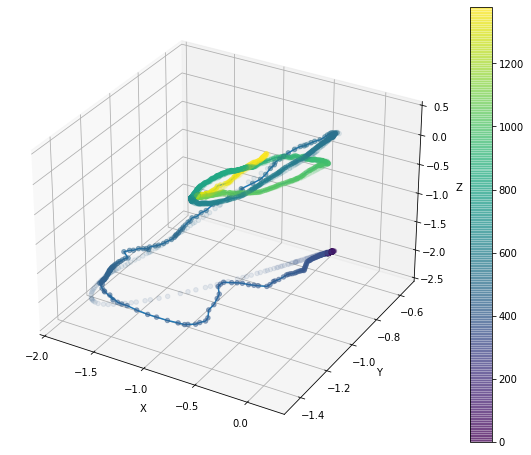

Abnormal input: tensor([[[ 0.0679,  0.4305, -0.4504],
         [ 0.8034,  0.3499,  0.0720],
         [-0.1071, -0.4879,  0.5378],
         [-0.1893, -0.6358, -0.0343]]], device='cuda:0')


In [16]:
# Plot with raw inputs
test_latent_dist = plot_test(sensors_set, test_euler_set, look_back=5)

/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


MSE: 0.006636831443756819


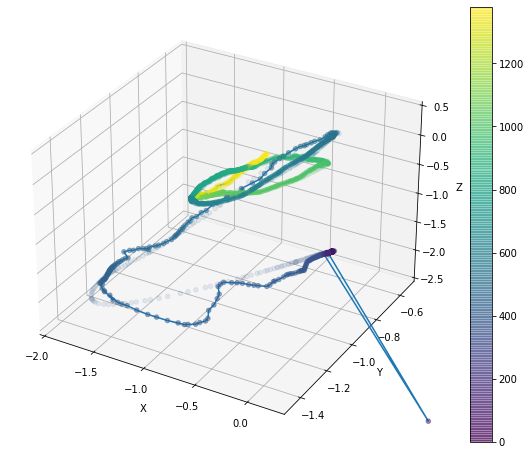

Abnormal input: tensor([[[ 0.0679,  0.4305, -0.4504],
         [ 0.8034,  0.3499,  0.0720],
         [-0.1071, -0.4879,  0.5378],
         [-0.1893, -0.6358, -0.0343]]], device='cuda:0')


In [17]:
# Plot with interpolated inputs
orig_latent_dist = plot_test(orig_sensors_set, test_euler_set, look_back=5)

In [18]:
test_latent_mean = torch.stack(test_latent_dist[0])
test_latent_var = torch.stack(test_latent_dist[1])

In [19]:
orig_latent_mean = torch.stack(orig_latent_dist[0])
orig_latent_var = torch.stack(orig_latent_dist[1])

In [20]:
np.set_printoptions(precision=3, suppress=True)

In [21]:
test_latent_mean

tensor([[[ -3.0812,   1.2427,  -6.8814,   1.6693,   7.1275,   2.1662,   1.3573,
            4.7896,  -1.7119,  -5.2970,  -2.8921,   3.8576,  -2.8738,  -6.5445,
           -7.1225,  -0.3503]],

        [[ -0.2467,   4.5612,  -4.1844,   0.5210,   6.5653,   5.4577,  -0.2681,
           -3.1519,   3.5289,  -6.1853, -15.6389,  -3.2510,   1.5703,   8.0196,
           -8.1216,  -4.7009]],

        [[ -3.1303,  -2.2482,   5.6757,  -9.1609, -10.8033,   1.7061,   1.5684,
           -2.2543,  -5.0621,   2.3271,  -5.4959,   4.6894,   2.3343,   6.7220,
           -5.4753,   4.1169]],

        [[ -1.5886,  -1.4113,   1.6024,  -3.8703,  -3.3963,   5.5004,   1.5702,
            7.1384,   3.0601,  -6.6358,  -2.2268,   6.4907,  -4.4554,   8.8876,
           -3.5252,   1.9820]]], device='cuda:0')

In [22]:
orig_latent_mean

tensor([[[ -3.0812,   1.2427,  -6.8814,   1.6693,   7.1275,   2.1662,   1.3573,
            4.7896,  -1.7119,  -5.2970,  -2.8921,   3.8576,  -2.8738,  -6.5445,
           -7.1225,  -0.3503]],

        [[ -0.2467,   4.5612,  -4.1844,   0.5210,   6.5653,   5.4577,  -0.2681,
           -3.1519,   3.5289,  -6.1853, -15.6389,  -3.2510,   1.5703,   8.0196,
           -8.1216,  -4.7009]],

        [[ -3.1303,  -2.2482,   5.6757,  -9.1609, -10.8033,   1.7061,   1.5684,
           -2.2543,  -5.0621,   2.3271,  -5.4959,   4.6894,   2.3343,   6.7220,
           -5.4753,   4.1169]],

        [[ -1.5886,  -1.4113,   1.6024,  -3.8703,  -3.3963,   5.5004,   1.5702,
            7.1384,   3.0601,  -6.6358,  -2.2268,   6.4907,  -4.4554,   8.8876,
           -3.5252,   1.9820]]], device='cuda:0')

In [23]:
(test_latent_mean - orig_latent_mean).abs().cpu().numpy()

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
      dtype=float32)

In [24]:
(test_latent_var - orig_latent_var).abs().cpu().numpy()

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
      dtype=float32)

In [25]:
test_latent_var

tensor([[[7.8986e-04, 3.3626e-03, 7.1215e-04, 4.3613e-03, 7.1180e-05,
          2.5514e-03, 3.7336e-03, 9.0581e-05, 8.1833e-05, 5.3813e-05,
          9.9989e-04, 3.0029e-04, 1.0426e-03, 6.4608e-05, 1.0439e-05,
          1.5053e-05]],

        [[2.8316e-03, 1.3221e-02, 1.3867e-04, 2.2507e-03, 1.0808e-05,
          1.1661e-03, 1.1681e-02, 7.4767e-05, 7.1196e-05, 1.8966e-05,
          3.3404e+02, 4.7029e-04, 1.0948e-04, 2.9688e-04, 1.4674e-02,
          1.0433e-04]],

        [[4.5338e-03, 7.5420e-04, 1.1171e-04, 5.1290e-04, 3.3681e-04,
          2.8569e-04, 4.0788e-04, 1.5738e-04, 1.0174e-05, 3.4962e-03,
          1.4049e-03, 6.9221e-05, 2.5128e-05, 2.5563e-04, 2.1664e-04,
          5.9151e-04]],

        [[3.0792e-02, 8.6442e-04, 6.6913e-05, 6.6561e-04, 5.8500e-05,
          2.0045e-02, 1.6537e-02, 1.3591e-04, 4.9014e-04, 5.7005e-05,
          3.2993e-03, 1.1979e-04, 1.5979e-03, 1.1454e-04, 8.9883e-04,
          5.5519e-04]]], device='cuda:0')

In [26]:
orig_latent_var

tensor([[[7.8986e-04, 3.3626e-03, 7.1215e-04, 4.3613e-03, 7.1180e-05,
          2.5514e-03, 3.7336e-03, 9.0581e-05, 8.1833e-05, 5.3813e-05,
          9.9989e-04, 3.0029e-04, 1.0426e-03, 6.4608e-05, 1.0439e-05,
          1.5053e-05]],

        [[2.8316e-03, 1.3221e-02, 1.3867e-04, 2.2507e-03, 1.0808e-05,
          1.1661e-03, 1.1681e-02, 7.4767e-05, 7.1196e-05, 1.8966e-05,
          3.3404e+02, 4.7029e-04, 1.0948e-04, 2.9688e-04, 1.4674e-02,
          1.0433e-04]],

        [[4.5338e-03, 7.5420e-04, 1.1171e-04, 5.1290e-04, 3.3681e-04,
          2.8569e-04, 4.0788e-04, 1.5738e-04, 1.0174e-05, 3.4962e-03,
          1.4049e-03, 6.9221e-05, 2.5128e-05, 2.5563e-04, 2.1664e-04,
          5.9151e-04]],

        [[3.0792e-02, 8.6442e-04, 6.6913e-05, 6.6561e-04, 5.8500e-05,
          2.0045e-02, 1.6537e-02, 1.3591e-04, 4.9014e-04, 5.7005e-05,
          3.2993e-03, 1.1979e-04, 1.5979e-03, 1.1454e-04, 8.9883e-04,
          5.5519e-04]]], device='cuda:0')

In [27]:
abnormal_idx = np.where(np.abs(sensors_set - orig_sensors_set) > 0.5)

In [28]:
abnormal_idx

(array([  2282,   8341,   9973,   9973,  10966,  10966,  15366,  15366,
         15533,  15533,  16112,  19511,  19837,  21644,  23209,  25411,
         25411,  25411,  26078,  26078,  29774,  36536,  37016,  38799,
         41133,  42230,  49466,  50623,  50623,  51516,  52317,  56390,
         57018,  59564,  64660,  65905,  65905,  65905,  68107,  68424,
         68719,  68719,  73142,  73142,  76201,  77824,  79089,  79089,
         83516,  83517,  83518,  83531,  83703,  83703,  83999,  83999,
         83999,  85079,  85079,  86333,  86475,  86475,  89410,  89781,
         92669,  92669,  96963,  97906,  99178, 100201, 100994, 103764,
        106670, 108479, 108479, 111319, 111367, 118610, 118610, 119145,
        121835, 124462, 132913, 138256, 142914, 142914, 144299, 147984,
        151531, 151531, 151531, 157099, 157153, 157153, 159824, 166624,
        166624, 166624, 166686, 168036, 168383, 168383, 168383, 170329,
        170329, 170329, 172342, 173478, 176301, 176301, 181441, 